In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization

In [4]:
import tensorflow as tf

# Clear the default graph stack and reset the global default graph.
tf.compat.v1.reset_default_graph()

# Set memory growth on for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Optionally, you can also set GPU options like this:
# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])


# Data Preparation

In [7]:
dataset, dataset_info = tfds.load('malaria',with_info=True,shuffle_files=True,as_supervised=True,split=['train'])

In [8]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [9]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator())
      )

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [10]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [11]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [12]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

# Data Visualization

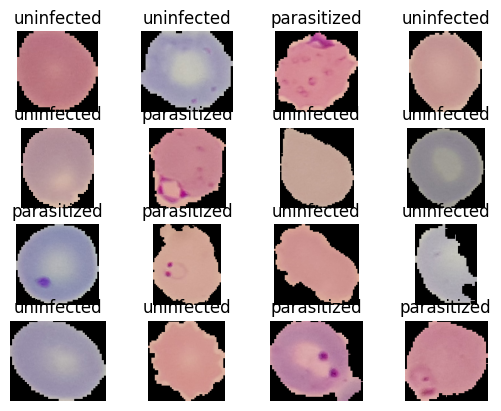

In [13]:
# Iterate through the first 16 elements of train_dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    # Create a subplot in a 4x4 grid, with the current index + 1 as the subplot number
    ax = plt.subplot(4, 4, i + 1)
    # Display the image on the subplot
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# Data Processing

In [14]:
IMG_SIZE = 224
def resizing_rescale(image,label):
  return tf.image.resize(image, (IMG_SIZE,IMG_SIZE))/255.0, label

In [15]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [16]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


BECAUSE reshuffle_each_iteration WAS NOT VALID FOR THE FIRST SHUFFLE

In [17]:
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Creation

In [21]:
lenet_model = tf.keras.Sequential(
    [
        InputLayer(shape=(IMG_SIZE,IMG_SIZE,3)),

        Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=2,strides=2),

        Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=2,strides=2),

        Flatten(),

        Dense(100, activation="relu"),
        BatchNormalization(),
        Dense(10, activation="relu"),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)
lenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 6)    │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,749,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,751,707 (6.68 MB)

 Trainable params: 1,751,463 (6.68 MB)

 Non-trainable params: 244 (976.00 B)

In [27]:
lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics = ['accuracy']
    )

In [29]:
history = lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1
    )

Epoch 1/20
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9582 - loss: 0.1303

W0000 00:00:1716451728.651418     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9582 - loss: 0.1303 - val_accuracy: 0.9314 - val_loss: 0.2076
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9586 - loss: 0.1277 - val_accuracy: 0.9093 - val_loss: 0.5375
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9610 - loss: 0.1174 - val_accuracy: 0.9495 - val_loss: 0.1707
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9612 - loss: 0.1168 - val_accuracy: 0.9405 - val_loss: 0.1880
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9615 - loss: 0.1086 - val_accuracy: 0.9397 - val_loss: 0.2017
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9669 - loss: 0.1022 - val_accuracy: 0.9412 - val_loss: 0.2065
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9684 - loss: 0.0925 - val_accuracy: 0.9492 - val_loss: 0.1709
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.9666 - loss: 0.1010 - val_accurac

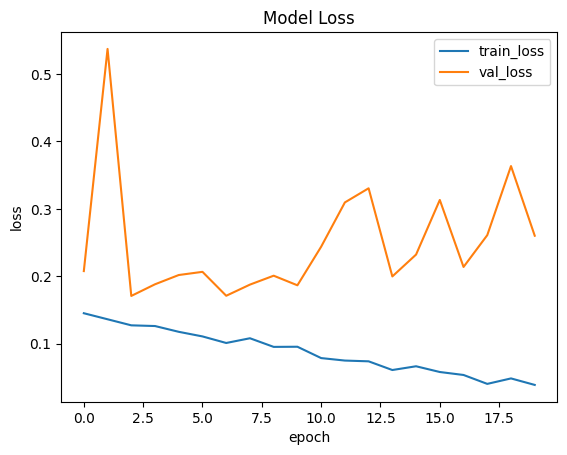

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

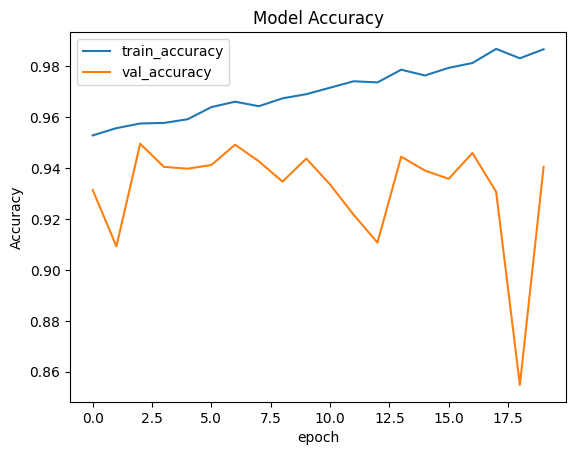

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Model Evaluation and Testing  

In [35]:
test_dataset = test_dataset.batch(1)

In [36]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [34]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9381 - loss: 0.2848


[0.28916865587234497, 0.9321726560592651]

In [40]:
def parasite_or_not(x):
    if (x<0.5):
        return str('Parasite')
    else:
        return str("Unaffected")

In [41]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


'Unaffected'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


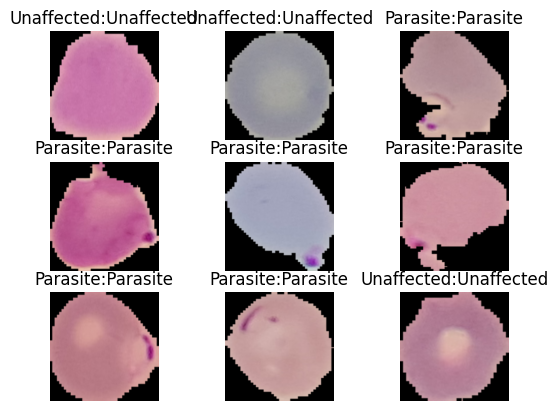

In [43]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  
  plt.axis('off')
     

In [64]:
lenet_model.save("MalariaModel.h5")

In [65]:
from IPython.display import FileLink
FileLink(r'MalariaModel.h5')

/kaggle/working/MalariaModel.h5

In [47]:
lenel_loaded_model = tf.keras.models.load_model('MalariaModel.keras')
lenel_loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 6)    │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,749,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,254,635 (20.04 MB)

 Trainable params: 1,751,463 (6.68 MB)

 Non-trainable params: 244 (976.00 B)

 Optimizer params: 3,502,928 (13.36 MB)